# cMLP Lagged VAR Demo

- In this notebook, we train a cMLP model on linear VAR data with lagged interactions.
- After examining the Granger causality discovery, we train a debiased model using only the discovered interactions.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from synthetic import simulate_lorenz_96_mine, generator1, Causal_Figure, standardise
from models.cmlp import cMLP, cMLPSparse, train_model_ista, train_unregularized

In [2]:
# For GPU acceleration
device = torch.device('cuda')

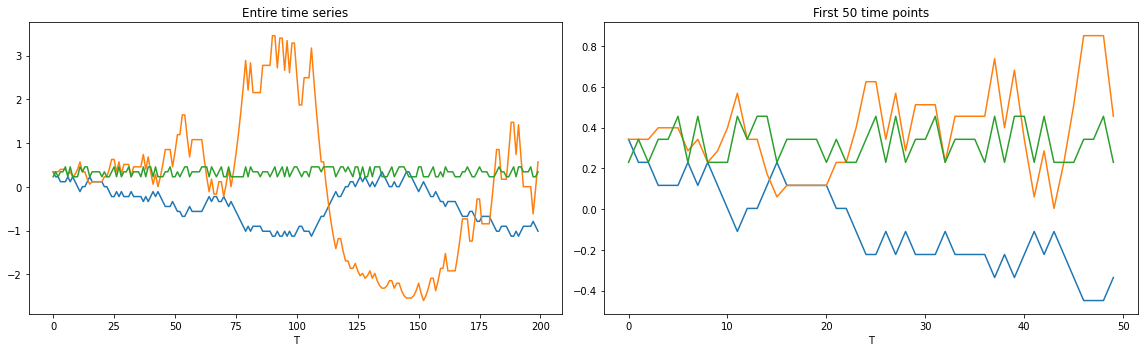

In [3]:
# Simulate data
X_np, GC_l = generator1(T=200,alpha=0.5)
X_np = standardise(X_np)
X = torch.tensor(X_np[np.newaxis], dtype=torch.float32, device=device)

# Plot data
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(X_np)
axarr[0].set_xlabel('T')
axarr[0].set_title('Entire time series')
axarr[1].plot(X_np[:50])
axarr[1].set_xlabel('T')
axarr[1].set_title('First 50 time points')
plt.tight_layout()
plt.show()

# Still need to tune $\lambda$ and perhaps lr

In [4]:
# Set up model
cmlp = cMLP(X.shape[-1], lag=1, hidden=[100]).cuda(device=device)

In [5]:
# Train with ISTA
train_loss_list = train_model_ista(
    cmlp, X, lam=0.012, lam_ridge=0.05, lr=1e-2, penalty='H', max_iter=50000,
    check_every=100)

----------Iter = 100----------
Loss = 0.187519
Variable usage = 100.00%
----------Iter = 200----------
Loss = 0.178624
Variable usage = 100.00%
----------Iter = 300----------
Loss = 0.173421
Variable usage = 100.00%
----------Iter = 400----------
Loss = 0.169632
Variable usage = 100.00%
----------Iter = 500----------
Loss = 0.166643
Variable usage = 100.00%
----------Iter = 600----------
Loss = 0.164189
Variable usage = 100.00%
----------Iter = 700----------
Loss = 0.162120
Variable usage = 100.00%
----------Iter = 800----------
Loss = 0.160396
Variable usage = 100.00%
----------Iter = 900----------
Loss = 0.158925
Variable usage = 100.00%
----------Iter = 1000----------
Loss = 0.157645
Variable usage = 100.00%
----------Iter = 1100----------
Loss = 0.156505
Variable usage = 100.00%
----------Iter = 1200----------
Loss = 0.155477
Variable usage = 100.00%
----------Iter = 1300----------
Loss = 0.154543
Variable usage = 100.00%
----------Iter = 1400----------
Loss = 0.153684
Variable usa

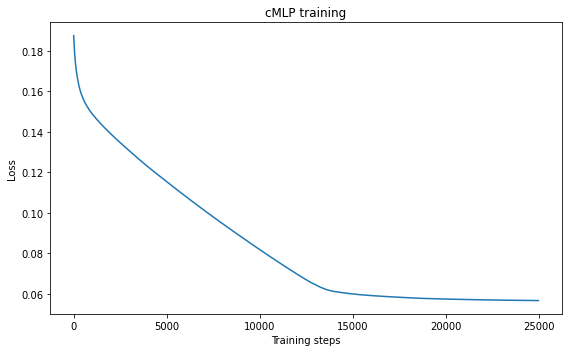

In [6]:
# Loss function plot
plt.figure(figsize=(8, 5))
plt.plot(50 * np.arange(len(train_loss_list)), train_loss_list)
plt.title('cMLP training')
plt.ylabel('Loss')
plt.xlabel('Training steps')
plt.tight_layout()
plt.show()

4 %


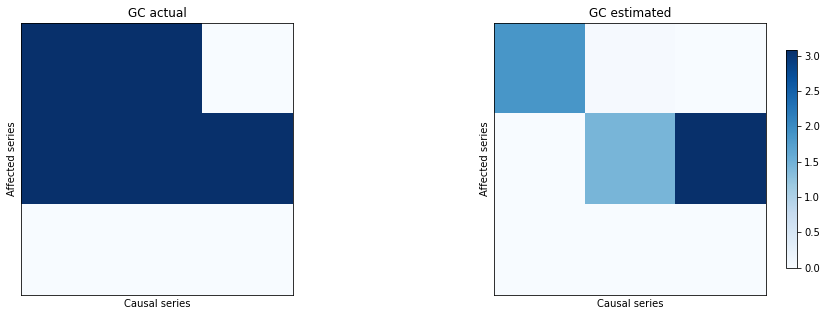

In [7]:
GC_est = cmlp.GC().cpu().data.numpy()
Causal_Figure(GC_est,cmlp.GC(ignore_lag=False, threshold=False).cpu().data.numpy())
print(np.sum(GC_est==GC_l[0]),"%")